In [1]:
from torchvision import datasets, transforms
import torch

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)



100%|██████████| 26421880/26421880 [00:01<00:00, 13567745.19it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 267926.45it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4962090.72it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6346936.21it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Batch shape: torch.Size([64, 1, 28, 28])


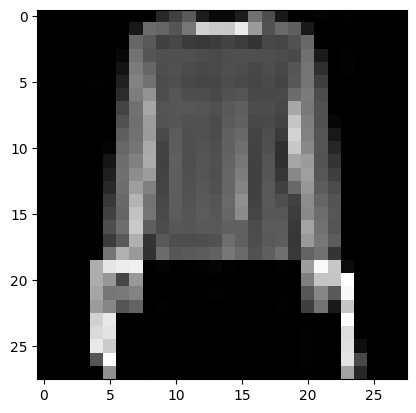

In [3]:
import matplotlib.pyplot as plt

# Get one batch of data
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(f"Batch shape: {images.shape}")  # Should be (batch_size, channels, height, width)

# Display one image
def show_image(image):
    # Unnormalize the image: x' = x * std + mean
    # image2 = image * 0.5 + 0.5  # Rescale from [-1, 1] to [0, 1]
    plt.imshow(image.squeeze(), cmap="gray")
    plt.show()
    # plt.imshow(image2.squeeze(), cmap="gray")
    # plt.show()

show_image(images[0])


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Architecture 2


In [6]:
import torch.nn as nn
import torch.optim as optim


class Reshape(nn.Module):
    def __init__(self, *shape):
        super().__init__()
        self.shape = shape
    def forward(self, x):
        return x.reshape(x.size(0), *self.shape)

class ConditionalGenerator(nn.Module):
    def __init__(self, dim_z=64, num_channels=1, num_classes=10):
        super().__init__()
        self.dim_z = dim_z
        self.num_classes = num_classes

        self.net = nn.Sequential(
            nn.Linear(dim_z + num_classes, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),

            nn.Linear(512, 128 * 7 * 7),
            nn.BatchNorm1d(128 * 7 * 7),
            nn.ReLU(inplace=True),
            Reshape(128, 7, 7),


            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 7x7 -> 14x14
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),


            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 14x14 -> 28x28
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),


            nn.Conv2d(32, 16, kernel_size=3, padding=1),  # 28x28
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),


            nn.Conv2d(16, num_channels, kernel_size=3, padding=1),  # 28x28
            nn.Tanh()  # to [-1, 1]
        )

    def forward(self, z, y):
        one_hot_y = torch.eye(self.num_classes, device=y.device)[y]
        z = torch.cat([z, one_hot_y], 1)
        return self.net(z)

class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.num_classes = num_classes

        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # 28x28 -> 14x14
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 14x14 -> 7x7
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 7x7 -> 3x3
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # 3x3
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            Reshape(256 * 3 * 3),
            nn.Linear(256 * 3 * 3, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, self.num_classes)
        )

    def forward(self, x, y):
        return self.net(x).gather(1, y.unsqueeze(1)).squeeze(1)

In [7]:
g = ConditionalGenerator().to(device)
d = ConditionalDiscriminator().to(device)

In [8]:
import tqdm
import torchvision
import torch.nn.functional as F


In [9]:
import os

output_dir = '/content/drive/MyDrive/A3_output_architecture2'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)


## dcgan

In [10]:
g = ConditionalGenerator().to(device)
d = ConditionalDiscriminator().to(device)

In [11]:
import os

output_dir = '/content/drive/MyDrive/A3_output_architecture2/dcgan'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [12]:
def cdcgan_loss(g, d, x_real, y_real, *, device):
    batch_size = x_real.shape[0]
    z = torch.randn(batch_size, g.dim_z, device=device)

    x_fake = g(z, y_real.to(device))

    # use d to give scores for real and fake images
    real_logits = d(x_real.to(device), y_real.to(device))
    fake_logits = d(x_fake.to(device), y_real.to(device))

    # calculate the loss of d, hope the distance between real image and real label is small
    real_labels = torch.ones(batch_size, device=device)
    fake_labels = torch.zeros(batch_size, device=device)
    real_loss = F.binary_cross_entropy_with_logits(real_logits, real_labels)
    fake_loss = F.binary_cross_entropy_with_logits(fake_logits, fake_labels)
    d_loss = real_loss + fake_loss

    # loss of g, hope the distance between fake image and real label is small
    gen_labels = torch.ones(batch_size, device=device)
    g_loss = F.binary_cross_entropy_with_logits(fake_logits, gen_labels)

    return d_loss, g_loss


In [13]:
z_test = torch.randn(10, 1, g.dim_z).repeat(1, 10, 1).reshape(100, g.dim_z).to(device)
y_test = torch.arange(10).repeat(10).to(device)

g_optimizer = torch.optim.Adam(g.parameters(), 1e-3, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(d.parameters(), 1e-3, betas=(0.5, 0.999))

global_step = 0
num_epochs = 1

dc_g_loss = []
dc_d_loss = []

for _ in range(num_epochs):
    for x_real, y_real in tqdm.tqdm(train_loader):
        x_real, y_real = x_real.to(device), y_real.to(device)

        d_loss, g_loss = cdcgan_loss(g, d, x_real, y_real, device=device)

        d_optimizer.zero_grad()
        d_loss.backward(retain_graph=True)


        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        d_optimizer.step()

        dc_g_loss.append(g_loss.item())
        dc_d_loss.append(d_loss.item())

        global_step += 1

        if global_step % 50 == 0:
            with torch.no_grad():
                g.eval()
                x_test = (g(z_test, y_test) + 1) / 2.
                torchvision.utils.save_image(
                    x_test, '%s/fake_%04d.png' % (output_dir, global_step),
                    nrow=10)
                g.train()

    with torch.no_grad():
        torch.save((g, d), '%s/model_%04d.pt' % (output_dir, global_step))




100%|██████████| 938/938 [00:25<00:00, 36.30it/s]


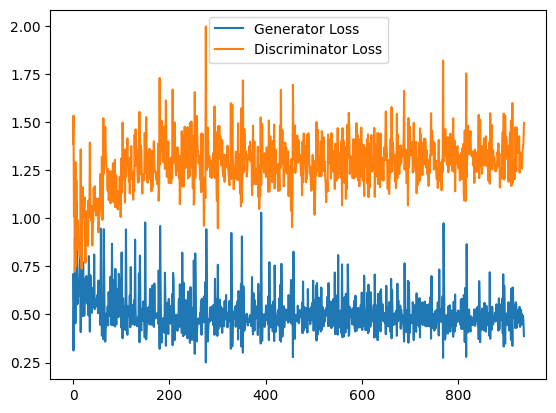

In [14]:
import pickle
import matplotlib.pyplot as plt

plt.plot(dc_g_loss, label='Generator Loss')
plt.plot(dc_d_loss, label='Discriminator Loss')
plt.legend()
plt.show()

In [15]:
import csv


output_dir = '/content/drive/MyDrive/A3_output_architecture2/dcgan'
file_path = f'{output_dir}/losses.csv'


with open(file_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['g_loss', 'd_loss'])
    writer.writerows(zip(dc_g_loss, dc_d_loss))


## wgan

In [16]:
def compute_d_loss(g, d, x_real, y_real, *, device):
    batch_size = x_real.shape[0]
    z = torch.randn(batch_size, g.dim_z, device=device)

    x_fake = g(z, y_real.to(device))

    real_scores = d(x_real.to(device), y_real.to(device))
    fake_scores = d(x_fake.detach(), y_real.to(device))

    d_loss = torch.mean(fake_scores) - torch.mean(real_scores)
    return d_loss

def compute_g_loss(g, d, y_real, *, device):
    batch_size = y_real.shape[0]
    z = torch.randn(batch_size, g.dim_z, device=device)

    x_fake = g(z, y_real.to(device))
    fake_scores = d(x_fake, y_real.to(device))

    g_loss = -torch.mean(fake_scores)
    return g_loss


In [24]:
import os
import shutil

output_dir = '/content/drive/MyDrive/A3_output_architecture2/wgan'

if os.path.exists(output_dir):
    shutil.rmtree(output_dir)

os.makedirs(output_dir)


In [32]:
# z_test = torch.randn(10, 1, g.dim_z).repeat(1, 10, 1).reshape(100, g.dim_z).to(device)
y_test = torch.arange(10).repeat(10).to(device)
z_test = torch.randn(100, g.dim_z).to(device)


g = ConditionalGenerator().to(device)
d = ConditionalDiscriminator().to(device)

g_optimizer = torch.optim.Adam(g.parameters(), 5e-4, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(d.parameters(), 5e-4, betas=(0.5, 0.999))
scheduler_g = torch.optim.lr_scheduler.StepLR(g_optimizer, step_size=1000, gamma=0.9)
scheduler_d = torch.optim.lr_scheduler.StepLR(d_optimizer, step_size=1000, gamma=0.9)


global_step = 0
num_epochs = 1
clip_value = 0.1
wgan_g_loss = []
wgan_d_loss = []

for epoch in range(num_epochs):
    for x_real, y_real in tqdm.tqdm(train_loader):
        x_real, y_real = x_real.to(device), y_real.to(device)


        for _ in range(1):
            d_loss = compute_d_loss(g, d, x_real, y_real, device=device)

            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()


            for p in d.parameters():
                p.data.clamp_(-clip_value, clip_value)


        g_loss = compute_g_loss(g, d, y_real, device=device)

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        scheduler_g.step()
        scheduler_d.step()


        wgan_g_loss.append(g_loss.item())
        wgan_d_loss.append(d_loss.item())

        global_step += 1


        if global_step % 100 == 0:
            with torch.no_grad():
                g.eval()
                x_test = (g(z_test, y_test) + 1) / 2.
                torchvision.utils.save_image(
                    x_test, '%s/fake_%04d.png' % (output_dir, global_step),
                    nrow=10)
                g.train()


    with torch.no_grad():
        torch.save((g, d), '%s/model_%04d.pt' % (output_dir, global_step))




100%|██████████| 938/938 [00:24<00:00, 37.97it/s]


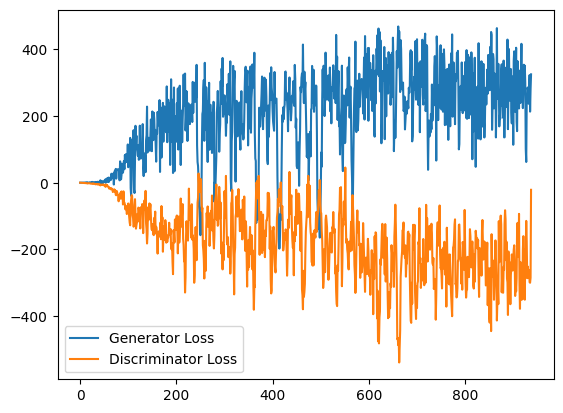

In [33]:
plt.plot(wgan_g_loss, label='Generator Loss')
plt.plot(wgan_d_loss, label='Discriminator Loss')
plt.legend()
plt.show()

In [34]:
import csv

output_dir = '/content/drive/MyDrive/A3_output_architecture2/wgan'
file_path = f'{output_dir}/losses.csv'


with open(file_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['g_loss', 'd_loss'])
    writer.writerows(zip(wgan_g_loss, wgan_d_loss))

## wgan-gp

In [36]:
import os

output_dir = '/content/drive/MyDrive/A3_output_architecture2/wgan_gp'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [38]:
g = ConditionalGenerator().to(device)
d = ConditionalDiscriminator().to(device)

g_optimizer = torch.optim.Adam(g.parameters(), 1e-3, betas=(0.5, 0.999))
d_optimizer = torch.optim.Adam(d.parameters(), 1e-3, betas=(0.5, 0.999))

global_step = 0
num_epochs = 1
n_critic = 2

wgangp_g_loss = []
wgangp_d_loss = []


def cwgan_gp_loss(g, d, x_real, y_real, *, device, lambda_gp=10):
    batch_size = x_real.shape[0]
    z = torch.randn(batch_size, g.dim_z, device=device)

    x_fake = g(z, y_real.to(device))

    real_scores = d(x_real.to(device), y_real.to(device))
    fake_scores = d(x_fake.to(device), y_real.to(device))


    d_loss = torch.mean(fake_scores) - torch.mean(real_scores)


    alpha = torch.rand(batch_size, 1, 1, 1, device=device)
    x_hat = alpha * x_real + (1 - alpha) * x_fake
    x_hat.requires_grad_(True)

    d_hat = d(x_hat, y_real.to(device))
    gradients = torch.autograd.grad(
        outputs=d_hat, inputs=x_hat,
        grad_outputs=torch.ones(d_hat.size(), device=device),
        create_graph=True, retain_graph=True
    )[0]
    slopes = torch.sqrt(torch.sum(gradients.pow(2), dim=[1, 2, 3]))
    gradient_penalty = torch.mean((slopes - 1) ** 2)

    d_loss = d_loss + lambda_gp * gradient_penalty


    g_loss = -torch.mean(fake_scores)

    return d_loss, g_loss

def train_discriminator(g, d, x_real, y_real, d_optimizer, device, lambda_gp=10):
    d_loss, _ = cwgan_gp_loss(g, d, x_real, y_real, device=device, lambda_gp=lambda_gp)

    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    return d_loss.item()


def train_generator(g, d, x_real, y_real, g_optimizer, device):
    _, g_loss = cwgan_gp_loss(g, d, x_real, y_real, device=device)

    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    return g_loss.item()

for _ in range(num_epochs):
    for x_real, y_real in tqdm.tqdm(train_loader):
        x_real, y_real = x_real.to(device), y_real.to(device)


        for _ in range(n_critic):
            d_loss_value = train_discriminator(g, d, x_real, y_real, d_optimizer, device)
        wgangp_d_loss.append(d_loss_value)


        g_loss_value = train_generator(g, d, x_real, y_real, g_optimizer, device)
        wgangp_g_loss.append(g_loss_value)

        global_step += 1

        if global_step % 50 == 0:
            with torch.no_grad():
                g.eval()
                x_test = (g(z_test, y_test) + 1) / 2.
                torchvision.utils.save_image(
                    x_test, '%s/fake_%04d.png' % (output_dir, global_step),
                    nrow=10)
                g.train()


    with torch.no_grad():
        torch.save((g, d), '%s/model_%04d.pt' % (output_dir, global_step))




100%|██████████| 938/938 [01:29<00:00, 10.43it/s]


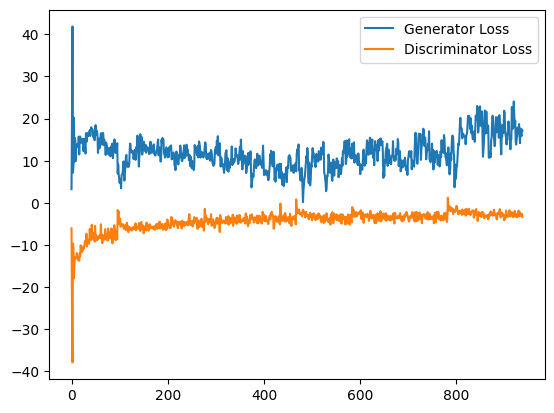

In [39]:
plt.plot(wgangp_g_loss, label='Generator Loss')
plt.plot(wgangp_d_loss, label='Discriminator Loss')
plt.legend()
plt.show()

In [40]:
import csv

output_dir = '/content/drive/MyDrive/A3_output_architecture2/wgan_gp'
file_path = f'{output_dir}/losses.csv'


with open(file_path, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['g_loss', 'd_loss'])
    writer.writerows(zip(wgangp_g_loss, wgangp_d_loss))

# Draw Plot

In [41]:
import csv

wgangp_g_loss = []
wgangp_d_loss = []

output_dir_wgangp = '/content/drive/MyDrive/A3_output_architecture2/wgan_gp'
file_path_wgangp = f'{output_dir_wgangp}/losses.csv'

with open(file_path_wgangp, 'r') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        wgangp_g_loss.append(float(row[0]))
        wgangp_d_loss.append(float(row[1]))

wgan_g_loss = []
wgan_d_loss = []

output_dir_wgan = '/content/drive/MyDrive/A3_output_architecture2/wgan'
file_path_wgan = f'{output_dir_wgan}/losses.csv'

with open(file_path_wgan, 'r') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        wgan_g_loss.append(float(row[0]))
        wgan_d_loss.append(float(row[1]))

dc_g_loss = []
dc_d_loss = []

output_dir_dcgan = '/content/drive/MyDrive/A3_output_architecture2/dcgan'
file_path_dcgan = f'{output_dir_dcgan}/losses.csv'

with open(file_path_dcgan, 'r') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        dc_g_loss.append(float(row[0]))
        dc_d_loss.append(float(row[1]))


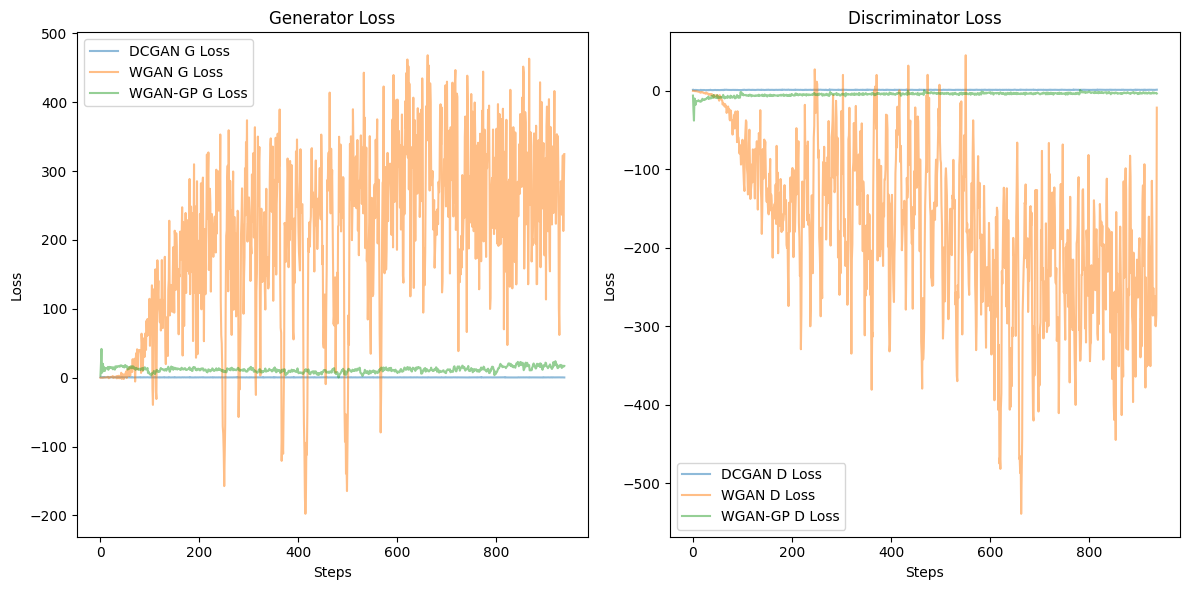

In [42]:
# Adjust the plot to have 'Steps' on the x-axis (assuming step data matches the length of loss data)

# Assuming steps are sequentially numbered based on the length of the losses
steps = list(range(len(dc_g_loss)))

plt.figure(figsize=(12, 6))

# Generator loss plot with steps on the x-axis
plt.subplot(1, 2, 1)
plt.plot(dc_g_loss, label='DCGAN G Loss', alpha=0.5)
plt.plot(wgan_g_loss, label='WGAN G Loss', alpha=0.5)
plt.plot(wgangp_g_loss, label='WGAN-GP G Loss', alpha=0.5)
plt.title('Generator Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

# Discriminator loss plot with steps on the x-axis
plt.subplot(1, 2, 2)
plt.plot(dc_d_loss, label='DCGAN D Loss', alpha=0.5)
plt.plot(wgan_d_loss, label='WGAN D Loss', alpha=0.5)
plt.plot(wgangp_d_loss, label='WGAN-GP D Loss', alpha=0.5)
plt.title('Discriminator Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()
